In [1]:
!pip install git+https://github.com/huggingface/datasets
!pip install sentencepiece
!pip install transformers[torch]
!pip install accelerate -U

  Cloning https://github.com/huggingface/datasets to /tmp/pip-req-build-t3ameved
  Running command git clone --filter=blob:none --quiet https://github.com/huggingface/datasets /tmp/pip-req-build-t3ameved
  Resolved https://github.com/huggingface/datasets to commit 13f18e3339e8e4c8d6205e9d0a93f41b9ed39f37
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 3.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 39.9/39.9 MB 23.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 11.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.1/194.1 kB 14.2 MB/s eta 0:00:00
  Created wheel for datasets: filename=datasets-3.0.1.dev0-py3-none-any.whl size=471089 sha256=bb2f75e112b9531ee09f0b6d4fa7a63cbf1a32fe047f0d55c28beb7fae39c26b
  Stored in directory: /tmp/pip-ephem-wheel-cache-hp9_03vz/wheels/7f/ba/ce/8f6

In [2]:
!pip install evaluate
!pip install sacrebleu

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 84.0/84.0 kB 2.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 51.8/51.8 kB 4.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 104.0/104.0 kB 8.7 MB/s eta 0:00:00


In [3]:
from datasets import load_dataset
from transformers import (
    MBartForConditionalGeneration, MBart50TokenizerFast,
    Seq2SeqTrainingArguments, Seq2SeqTrainer
  )
import torch
from torch.utils.data import random_split

In [4]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [5]:
data = []
with open("/content/drive/MyDrive/IITB.en-hi.en") as f2, open("/content/drive/MyDrive/IITB.en-hi.hi") as f1:
    for src, tgt in zip(f1, f2):
      data.append(
          {
              "translation":{
                  "inputs": src.strip(),
                  "targets": tgt.strip()
              }
          }
      )
print(f'total size of data is {len(data)}')

total size of data is 1659083


In [6]:
rem = int(0.02*len(data))
rem

33181

In [7]:
data_red = data[:rem]
len(data_red)

33181

In [8]:
split = 0.80
train_dataset, eval_dataset = random_split(data_red, lengths=[int((1-split)*len(data_red))+1, int(split*len(data_red))])

In [9]:
model = MBartForConditionalGeneration.from_pretrained("facebook/mbart-large-50-many-to-many-mmt")
tokenizer = MBart50TokenizerFast.from_pretrained("facebook/mbart-large-50-many-to-many-mmt",src_lang="hi_IN",tgt_lang="en_XX")

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:89: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


config.json:   0%|          | 0.00/1.43k [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/2.44G [00:00<?, ?B/s]

generation_config.json:   0%|          | 0.00/261 [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/529 [00:00<?, ?B/s]

sentencepiece.bpe.model:   0%|          | 0.00/5.07M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/649 [00:00<?, ?B/s]

/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:1601: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be depracted in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(


In [10]:
def data_collator(features: list):
    labels = [f["translation"]["targets"] if "translation" in f else "" for f in features]
    inputs = [f["translation"]["inputs"] if "translation" in f else "" for f in features]

    model_inputs = tokenizer(inputs, max_length=32, padding='max_length', truncation=True, return_tensors="pt")
    with tokenizer.as_target_tokenizer():
        labels = tokenizer(labels, max_length=32, padding='max_length', truncation=True, return_tensors="pt")

    model_inputs["labels"] = labels["input_ids"]
    return model_inputs

In [11]:
args = Seq2SeqTrainingArguments(output_dir="/content/drive/MyDrive/mbart_50_HindiToEnglish_reloaded/",
                        do_train=True,
                        do_eval=True,
                        evaluation_strategy="epoch",
                        per_device_train_batch_size=16,
                        per_device_eval_batch_size=16,
                        learning_rate=5e-5,
                        num_train_epochs=3,
                        logging_dir="/logs")

/usr/local/lib/python3.10/dist-packages/transformers/training_args.py:1525: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(


In [12]:
tokenizer.save_pretrained('/content/drive/MyDrive/mbart_50_HindiToEnglish_reloaded')

('/content/drive/MyDrive/mbart_50_HindiToEnglish_reloaded/tokenizer_config.json',
 '/content/drive/MyDrive/mbart_50_HindiToEnglish_reloaded/special_tokens_map.json',
 '/content/drive/MyDrive/mbart_50_HindiToEnglish_reloaded/sentencepiece.bpe.model',
 '/content/drive/MyDrive/mbart_50_HindiToEnglish_reloaded/added_tokens.json',
 '/content/drive/MyDrive/mbart_50_HindiToEnglish_reloaded/tokenizer.json')

In [13]:
trainer = Seq2SeqTrainer(model=model,
                 args=args,
                 data_collator=data_collator,
                 train_dataset=train_dataset,
                 eval_dataset=eval_dataset)

In [14]:
training_output = trainer.train()
print(training_output)

/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:4126: UserWarning: `as_target_tokenizer` is deprecated and will be removed in v5 of Transformers. You can tokenize your labels by using the argument `text_target` of the regular `__call__` method (either in the same call as your input texts if you use the same keyword arguments, or in a separate call.
  warnings.warn(


Epoch,Training Loss,Validation Loss
1,No log,0.000020
2,0.433800,0.000011
3,0.000000,0.000009


Some non-default generation parameters are set in the model config. These should go into a GenerationConfig file (https://huggingface.co/docs/transformers/generation_strategies#save-a-custom-decoding-strategy-with-your-model) instead. This warning will be raised to an exception in v4.41.
Non-default generation parameters: {'max_length': 200, 'early_stopping': True, 'num_beams': 5, 'forced_eos_token_id': 2}
/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:4126: UserWarning: `as_target_tokenizer` is deprecated and will be removed in v5 of Transformers. You can tokenize your labels by using the argument `text_target` of the regular `__call__` method (either in the same call as your input texts if you use the same keyword arguments, or in a separate call.
  warnings.warn(
Some non-default generation parameters are set in the model config. These should go into a GenerationConfig file (https://huggingface.co/docs/transformers/generation_strategies#save-a-custom

TrainOutput(global_step=1245, training_loss=0.17422251352445636, metrics={'train_runtime': 2146.0932, 'train_samples_per_second': 9.278, 'train_steps_per_second': 0.58, 'total_flos': 1348428775292928.0, 'train_loss': 0.17422251352445636, 'epoch': 3.0})


In [15]:
model = MBartForConditionalGeneration.from_pretrained("facebook/mbart-large-50-many-to-many-mmt")
tokenizer = MBart50TokenizerFast.from_pretrained("facebook/mbart-large-50-many-to-many-mmt",src_lang="hi_IN",tgt_lang="en_XX")

/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:1601: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be depracted in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(


In [16]:
inputs = "में छोटा बच्चा हूँ"
encoded = tokenizer(inputs, return_tensors="pt")

In [17]:
generated_tokens = model.generate(**encoded, forced_bos_token_id=tokenizer.lang_code_to_id["en_XX"])
tokenizer.batch_decode(generated_tokens, skip_special_tokens=True)

["I'm a little kid."]

In [18]:
import random
random.seed(69)

In [19]:
data_test = []
for i in range(100):
  data_test.append(data[random.randint(0,10000)])

In [20]:
def data_collector(features: list):
    labels = [f["translation"]["targets"] if "translation" in f else "" for f in features]
    inputs = [f["translation"]["inputs"] if "translation" in f else "" for f in features]
    return inputs, labels

In [21]:
hindi_test,english_test = data_collector(data_test)

In [22]:
english_test[0]

'IPython Console'

In [23]:
english_list=[]
for i in data:
  english_list.append(i['translation']['targets'])

In [24]:
graph_list=[]
english_graph_list=['Co _ mment',
 'Gaps',
 'Italic',
 'Deal another round',
 '_ Accessible',
 'Wins:',
 'No description',
 'Easthaven',
 'Saving',
 'Available new pluginviews',
 'Remove the kings',
 'You are searching for a king.',
 'Seahaven',
 'Thirteen',
 'Treize',
 'Stock left: ~ a',
 'Plugins']

In [25]:
for i in english_graph_list:
  graph_list.append(english_list.index(i))

In [58]:
hindi_list=[]
for i in data:
  hindi_list.append(i['translation']['inputs'])

In [59]:
hindi_graph_list=[]
for i in range(len(graph_list)):
  hindi_graph_list.append(hindi_list[graph_list[i]])

In [60]:
hindi_graph_list_copy=hindi_graph_list
hindi_graph_list_copy[0]="टिप्पणी (_ m)"

In [29]:
encoded_graph_list = []
for i in hindi_graph_list:
  encoded_graph_list.append(tokenizer(i,return_tensors="pt").input_ids.to(model.device))
decoded_graph_list = []
for i in range(len(encoded_graph_list)):
  generated_tokens = model.generate(input_ids=encoded_graph_list[i])
  decoded_graph_list.append(tokenizer.batch_decode(generated_tokens, skip_special_tokens=True))

In [30]:
encoded = tokenizer(hindi_test[0],return_tensors="pt")
generated_tokens = model.generate(**encoded, forced_bos_token_id=tokenizer.lang_code_to_id["en_XX"])
english_pred = tokenizer.batch_decode(generated_tokens, skip_special_tokens=True)

In [31]:
english_test[0].split()

['IPython', 'Console']

In [32]:
english_pred[0].split()

['iPython', 'console']

In [33]:
encoded_list = []
for i in hindi_test:
  encoded_list.append(tokenizer(i,return_tensors="pt"))

In [34]:
decoded_list = []
for i in range(len(encoded_list)):
  generated_tokens = model.generate(**encoded_list[i], forced_bos_token_id=tokenizer.lang_code_to_id["en_XX"])
  decoded_list.append(tokenizer.batch_decode(generated_tokens, skip_special_tokens=True))

In [35]:
len(decoded_list)

100

In [36]:
from nltk.translate.bleu_score import sentence_bleu

# Define your desired weights (example: higher weight for bi-grams)
weights = (0.25, 0.25, 0, 0)  # Weights for uni-gram, bi-gram, tri-gram, and 4-gram

# Reference and predicted texts (same as before)
reference = [['Give', 'your', 'application', 'an', 'accessibility', 'workout']]
predictions = ['Benefit', 'your', 'application', 'from', 'accessibility', 'exercises']

# Calculate BLEU score with weights
score = sentence_bleu([english_test[15].split()], decoded_list[15][0].split(),weights=weights)
print(score)

1.2213386697554703e-77


/usr/local/lib/python3.10/dist-packages/nltk/translate/bleu_score.py:552: UserWarning: 
The hypothesis contains 0 counts of 2-gram overlaps.
Therefore the BLEU score evaluates to 0, independently of
how many N-gram overlaps of lower order it contains.
Consider using lower n-gram order or use SmoothingFunction()
  warnings.warn(_msg)
/usr/local/lib/python3.10/dist-packages/nltk/translate/bleu_score.py:552: UserWarning: 
The hypothesis contains 0 counts of 3-gram overlaps.
Therefore the BLEU score evaluates to 0, independently of
how many N-gram overlaps of lower order it contains.
Consider using lower n-gram order or use SmoothingFunction()
  warnings.warn(_msg)
/usr/local/lib/python3.10/dist-packages/nltk/translate/bleu_score.py:552: UserWarning: 
The hypothesis contains 0 counts of 4-gram overlaps.
Therefore the BLEU score evaluates to 0, independently of
how many N-gram overlaps of lower order it contains.
Consider using lower n-gram order or use SmoothingFunction()
  warnings.warn(_

In [37]:
def check_bleu(reference,predictions):
  weights = (0.25, 0.25, 0, 0)
  score = sentence_bleu(reference, predictions, weights=weights)
  return score

In [38]:
scores = []
for i in range(len(decoded_list)):
  print(check_bleu([english_test[i].lower()],decoded_list[i][0].lower()))
  scores.append(check_bleu([english_test[i].lower()],decoded_list[i][0].lower()))

1.0
0.9554427922043668
0.7979439453790055
1.0
1.0
0.916559240945308
1.0
1.0
0.2722612485372157
7.426048372405372e-78
1.155070798672325e-77
0.7102992180127422
0.512183313947313
1.0
0.8642439478526603
1.0
1.0
0.29020462577805806
1.0
0.40289032152913296
0.049787068367863944
0.6730382052094637
0.44557127531844243
1.0
0.7175852914772134
0
0.8895593793168879
1.0
1.0
1.0
0.668740304976422
0.583645478143574
0.8891397050194614
0.7165313105737893
1.0
1.0
1.0
0.7330546575111153
1.0
0.9235495977650208
0.9556559893150806
0.5149052924789205
0.4071220775553065
1.0
0.7520488628055078
0.8885617783540561
0.28176928909495835
1.0
1.0
0.7311104457090247
0.5972450013620315
0.8103704262697159
1.0
0.9764540896763105
0.6223329772884784
0.7165313105737893
0.9084043091294747
1.0
1.0
0.8969341509296789
0.7564809207900101
0.4138080991773701
0.8852140475440834
1.0
1.0
0.44491422063377273
0.7082593633017147
1.0
0.628016973395869
0.6075629887883155
0.9306048591020996
0.14873131084329605
1.0270193092081295e-77
0.76191

In [39]:
comparision = []
for i in range(len(decoded_list)):
  comparision.append(hindi_test[i]+" : "+english_test[i].lower()+" : "+decoded_list[i][0].lower())

In [40]:
english_test[29:46]

['Force',
 'Redeals left: ~ a',
 'The game file to use',
 'No read',
 '_ Reload',
 'Selected columns',
 'Total:',
 'Select Program',
 'No executable for this file.',
 'Row',
 'Highlight last event entry',
 '% (rolename) s index% (num) d does not match row and column',
 'Doublets',
 'V _ alidate',
 'stock',
 'Whether or not to show the status bar',
 'Move ~ a off the board']

In [41]:
comparision[29:46]

['बाध्य करें : force : force',
 'ताश बांटना बाकीः ~ a : redeals left: ~ a : unallocated keys: ~ a',
 'खेल फ़ाइल उपयोग में : the game file to use : use game file',
 'नहीं पढ़ा : no read : not read',
 'पुन लोड करें : _ reload : reload',
 'चुने गए स्तंभ : selected columns : selected columns',
 'कुलः : total: : total:',
 'प्रोग्राम चुनें : select program : select program',
 'इस फाइल के लिए मेन्यू में : no executable for this file. : in the menu for this file',
 'पंक्ति : row : row',
 'अंतिम प्रविष्ट घटना को हाइलाइट करो : highlight last event entry : highlight last entered event',
 '% (rolename) s सूची% (num) d पंक्ति और स्तंभ से मेल नहीं खातेparent indexrow and column index : % (rolename) s index% (num) d does not match row and column : % (rolename) s list% (num) d does not match row and column index',
 'जोड़ा : doublets : couple',
 'सत्यापन : v _ alidate : authentication',
 'स्टाकslot type : stock : stock',
 'स्थिति-पट्टी दिखाएँ या नहीं : whether or not to show the status bar : whether to

In [42]:
decoded_list[29:46]

[['Force'],
 ['Unallocated keys: ~ a'],
 ['Use game file'],
 ['not read'],
 ['Reload'],
 ['Selected columns'],
 ['Total:'],
 ['Select Program'],
 ['In the menu for this file'],
 ['row'],
 ['Highlight last entered event'],
 ['% (rolename) s list% (num) d does not match row and column index'],
 ['couple'],
 ['authentication'],
 ['stock'],
 ['Whether to show the statusbar'],
 ['Move ~ a off the panel']]

In [43]:
import matplotlib.pyplot as plt

In [44]:
import pandas as pd
from pathlib import Path
from matplotlib.font_manager import FontProperties

# point to the font location with an absolute path
nirm = Path('/content/drive/MyDrive/Nirmala-UI.ttf')

# configure the Hindi font
hindi_font = FontProperties(fname=nirm)

In [45]:
graph_bleu=[]
for i in range(len(decoded_graph_list)):
  graph_bleu.append(check_bleu([english_graph_list[i].lower()],decoded_graph_list[i][0].lower()))

<ipython-input-46-80124e79786e>:11: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels(text, fontproperties=hindi_font)


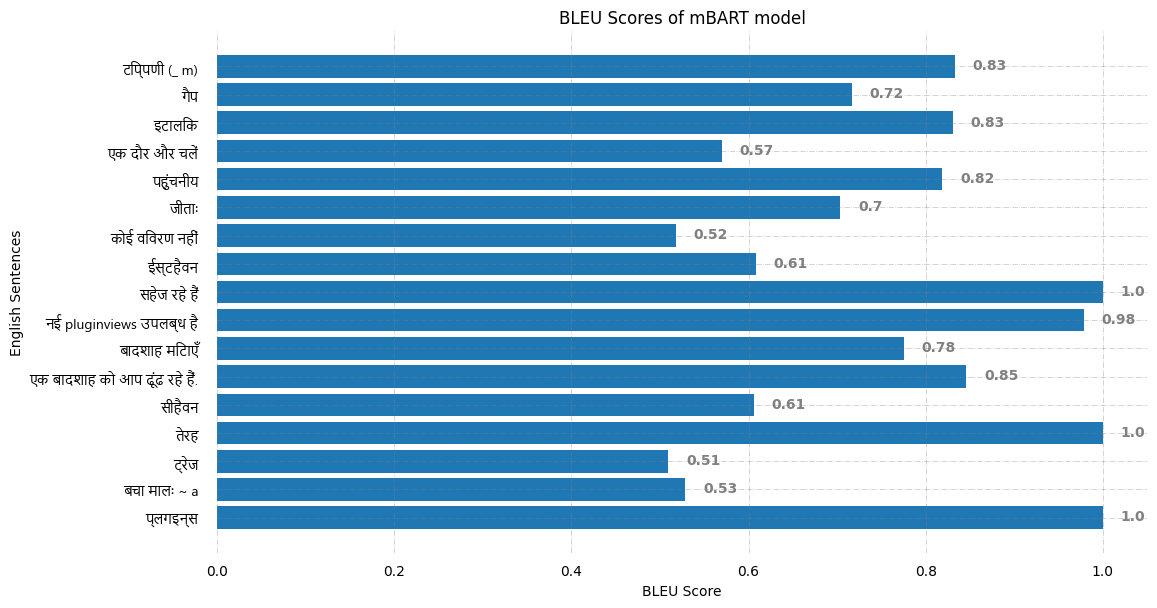

In [46]:
fig, ax = plt.subplots(figsize =(12, 6.77))
ax.barh(hindi_graph_list_copy, graph_bleu)
for s in ['top', 'bottom', 'left', 'right']:
    ax.spines[s].set_visible(False)
ax.xaxis.set_ticks_position('none')
ax.yaxis.set_ticks_position('none')
ax.xaxis.set_tick_params(pad = 5)
ax.yaxis.set_tick_params(pad = 10)

text = [item.get_text() for item in ax.get_yticklabels()]
ax.set_yticklabels(text, fontproperties=hindi_font)
for rect in ax.patches:
    # Find where everything is located
    height = rect.get_height()
    width = rect.get_width()
    x = rect.get_x()
    y = rect.get_y()

    # The width of the bar is the count value and can used as the label
    label_text = f'{width:.02f}'

    label_x = x + width / 2
    label_y = y + height / 2


ax.grid(color ='grey',
        linestyle ='-.', linewidth = 0.6,
        alpha = 0.4)
ax.invert_yaxis()
for i in ax.patches:
    plt.text(i.get_width()+0.02, i.get_y()+0.5,
             str(round((i.get_width()), 2)),
             fontsize = 10, fontweight ='bold',
             color ='grey')
plt.title('BLEU Scores of mBART model')
plt.xlabel('BLEU Score')
plt.ylabel('English Sentences')
plt.show()

In [47]:
hindi_test[38]

'पंक्ति'

In [48]:
from nltk.translate import chrf_score

In [49]:
chrff=chrf_score

In [50]:
decoded_list[0]

['iPython console']

In [51]:
english_test[0]

'IPython Console'

In [52]:
chrf_score.sentence_chrf(english_test[0].split(),decoded_list[0][0].split())

0.5767861767861767

In [53]:
def check_chrf(reference,predictions):
  score = chrf_score.sentence_chrf(reference, predictions,min_len=1,max_len=3)
  return score

In [54]:
chrfscores = []
for i in range(len(decoded_list)):
  print(check_chrf(english_test[i].lower().split(),decoded_list[i][0].lower().split()))
  chrfscores.append(check_chrf([english_test[i].lower()],decoded_list[i][0].lower()))

1.0
0.9183526518450317
0.5911532629089881
1.0
1.0
0.8636322053753246
1.0
1.0
0.2878521495960616
0.11363636363636372
0.2666666666666668
0.5551137033109462
0.3950268817204301
1.0
0.7054368718486543
1.0
1.0
0.20322939871844922
1.0
0.5804488362627898
0.2806323016185874
0.5170297852430913
0.27579365079365076
1.0
0.5823424159783296
1e-16
0.823501480222497
1.0
1.0
1.0
0.38101383762192614
0.6639750614537414
0.7519083869720086
0.8444497917073978
1.0
1.0
1.0
0.5123702148225923
1.0
0.8994111222478173
0.9487583465302603
0.2689793866264455
0.21465428276573792
1.0
0.8060371782048855
0.7062908496732025
0.4872396909880116
1.0
1.0
0.9029628948739162
0.35191403920931147
0.6246315342425183
1.0
0.8964912280701754
0.2833333333333334
0.7461812683895737
0.8210658453545339
1.0
1.0
0.848943942368041
0.6009221196396882
0.5671349511921695
0.9755015641845818
1.0
1.0
0.29456442771283275
0.5061596360856816
1.0
0.38566313996673934
0.49604158488123035
0.9833047357325136
0.11871415232759774
0.3030303030303031
0.657507

In [55]:
chrfscores[29:46]

[1.0,
 0.38101383762192614,
 0.6639750614537414,
 0.7519083869720086,
 0.8444497917073978,
 1.0,
 1.0,
 1.0,
 0.5123702148225923,
 1.0,
 0.8994111222478173,
 0.9487583465302603,
 0.2689793866264455,
 0.21465428276573792,
 1.0,
 0.8060371782048855,
 0.7062908496732025]

In [62]:
from statistics import mean

In [63]:
mean(scores)

0.720346795500051

In [64]:
mean(chrfscores)

0.6827670042981474

In [65]:
graph_chrf=[]
for i in range(len(decoded_graph_list)):
  graph_chrf.append(check_chrf([english_graph_list[i].lower()],decoded_graph_list[i][0].lower()))

<ipython-input-66-68c6752ac204>:11: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels(text, fontproperties=hindi_font)


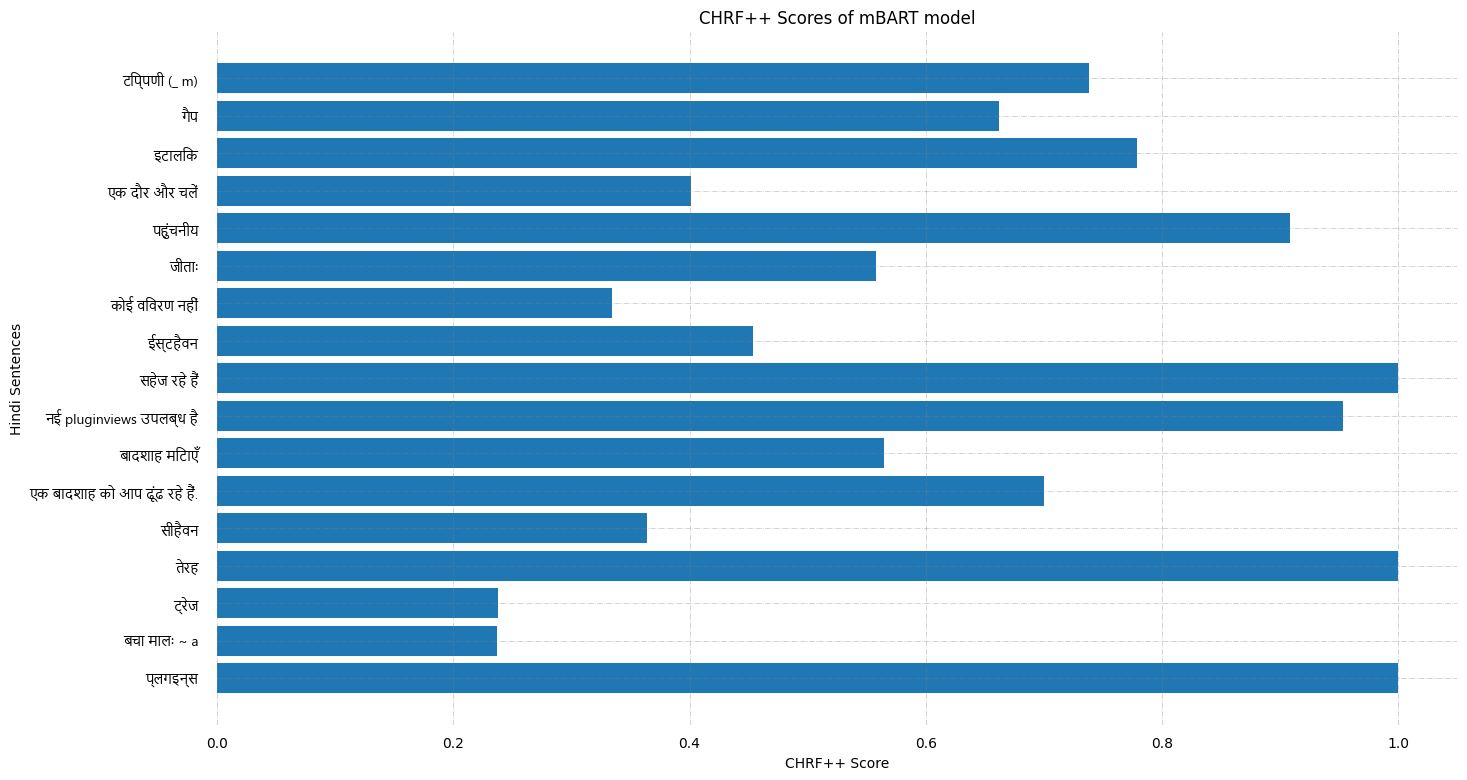

In [66]:
fig, ax = plt.subplots(figsize =(16, 9))
ax.barh(hindi_graph_list_copy, graph_chrf)
for s in ['top', 'bottom', 'left', 'right']:
    ax.spines[s].set_visible(False)
ax.xaxis.set_ticks_position('none')
ax.yaxis.set_ticks_position('none')
ax.xaxis.set_tick_params(pad = 5)
ax.yaxis.set_tick_params(pad = 10)

text = [item.get_text() for item in ax.get_yticklabels()]
ax.set_yticklabels(text, fontproperties=hindi_font)
for rect in ax.patches:
    # Find where everything is located
    height = rect.get_height()
    width = rect.get_width()
    x = rect.get_x()
    y = rect.get_y()

    # The width of the bar is the count value and can used as the label
    label_text = f'{width:.02f}'

    label_x = x + width / 2
    label_y = y + height / 2


ax.grid(color ='grey',
        linestyle ='-.', linewidth = 0.6,
        alpha = 0.4)
ax.invert_yaxis()
'''
for i in ax.patches:
    plt.text(i.get_width()+0.02, i.get_y()+0.5,
             str(round((i.get_width()), 2)),
             fontsize = 10, fontweight ='bold',
             color ='grey')'''
plt.title('CHRF++ Scores of mBART model')
plt.xlabel('CHRF++ Score')
plt.ylabel('Hindi Sentences')
plt.show()

In [67]:
import numpy as np

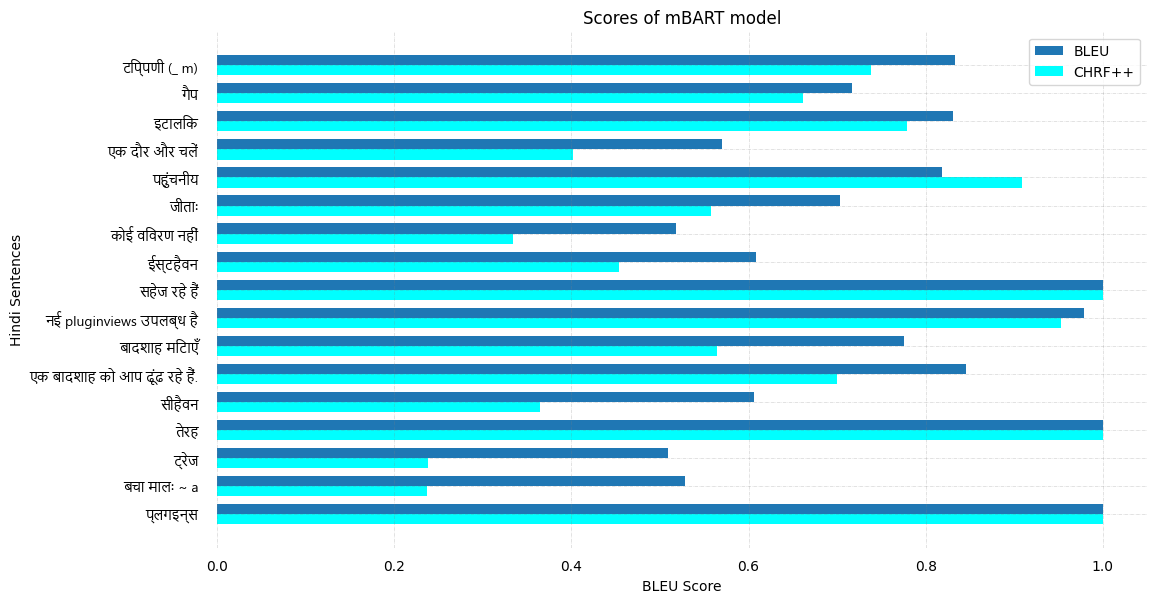

In [68]:
fig, ax = plt.subplots(figsize =(12, 6.7))
y=np.arange(17)
width=0.36
ax.barh(y-0.18, graph_bleu,width,label='BLEU')
ax.barh(y+0.18, graph_chrf,width,label='CHRF++',color='cyan')
plt.yticks(y, hindi_graph_list_copy)
ax.legend(fontsize=10)
for s in ['top', 'bottom', 'left', 'right']:
    ax.spines[s].set_visible(False)
ax.xaxis.set_ticks_position('none')
ax.yaxis.set_ticks_position('none')
ax.xaxis.set_tick_params(pad = 5)
ax.yaxis.set_tick_params(pad = 10)

text = [item.get_text() for item in ax.get_yticklabels()]
ax.set_yticklabels(text, fontproperties=hindi_font)
for rect in ax.patches:
    # Find where everything is located
    height = rect.get_height()
    width = rect.get_width()
    x = rect.get_x()
    y = rect.get_y()

    # The width of the bar is the count value and can used as the label
    label_text = f'{width:.02f}'

    label_x = x + width / 2
    label_y = y + height / 2


ax.grid(color ='grey',
        linestyle ='-.', linewidth = 0.4,
        alpha = 0.4)
ax.invert_yaxis()
'''
for i in ax.patches:
    plt.text(i.get_width()+0.02, i.get_y()+0.5,
             str(round((i.get_width()), 2)),
             fontsize = 10, fontweight ='bold',
             color ='grey')
'''
plt.title('Scores of mBART model')
plt.xlabel('BLEU Score')
plt.ylabel('Hindi Sentences')
plt.show()